In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

%matplotlib inline
np.random.seed(1)   

In [4]:
iris = load_iris()
x = iris.data
y = iris.target.reshape(-1, 1)

perm = np.random.permutation(y.size)
x = x[perm][:]
y = y[perm][:]

encoder = OneHotEncoder(categories='auto', dtype=np.int)
y = encoder.fit_transform(y).toarray()

scaler = MinMaxScaler()
x = scaler.fit_transform(x)

print(x.shape, y.shape)

(150, 4) (150, 3)


In [147]:
class NeuralNetwork():
    def __init__(self, x, y, params={}):
        self.x = x
        self.y = y
        
        self.lr = params['lr'] if 'lr' in params else 0.05
        self.ln = len(params['ln']) if 'ln' in params else 3
        self.l = params['ln'] if 'ln' in params else [8, 4, 3]
        
        self.output_dimen = y.shape[0]
        self.input_dimen = x.shape[0]
        self.m = y.shape[1]
        
        self.activation = self.relu if 'activation' in params and params['activation'] == 'relu' \
                                    else self.tanh
        self.activation_prime = self.relu_prime if self.activation == self.relu \
                                    else self.tanh_prime
        
        self.w = []
        self.b = []
        
        for l in range(self.ln):
            self.w.append(self.random_initialize(self.l[l], self.input_dimen if l == 0 else self.l[l-1]))
            self.b.append(self.random_initialize(1, 1))
        self.w.append(self.random_initialize(self.output_dimen, self.l[-1]))
        self.b.append(self.random_initialize(1, 1))
        
        for l in range(self.ln + 1):
            print(f'layer {l+1} -> w{self.w[l].shape}, b{self.b[l].shape}')
            
        print(f'total trainable params: {self.total_trainable_params()}')
            
    def random_initialize(self, *params):
        return 2 * np.random.randn(*params) - 1
    
    def total_trainable_params(self):
        temp = 0
        temp += np.sum([w.size for w in self.w])
        temp += np.sum([b.size for b in self.b])
        return temp
    
    def relu(self, x):
        return x * (x>0)
    
    def relu_prime(self, x):
        return np.where(x > 0, 1.0, 0.0)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_prime(self, x):
        return 1 - (np.tanh(x) ** 2)
    
    def loss(self, x):
        return np.mean(-self.y * np.log(x) - (1-self.y) * np.log(1-x))
    
    def loss_prime(self, x):
        return -(self.y/x) + ((1-self.y)/(1-x))
    
    def sigmoid(self, x):
        z = np.exp(x - np.max(x))
        return z / z.sum(axis=0)
    
    def sigmoid_prime(self, x):
        return x * (1-x)
    
    def forward_prop(self, x=None, one_hot=False):
        x = self.x if x == None else x
        
        layer_output = x
        for l in range(self.ln):
            layer_output = self.activation(np.dot(self.w[l], layer_output) + self.b[l])
        output = self.sigmoid(np.dot(self.w[-1], layer_output) + self.b[-1])
        
        if one_hot:
            output = output.T
            for i in range(output.shape[0]):
                temp = np.zeros(3)
                temp[np.argmax(output[i])] = 1
                output[i] = temp
                
            return output.astype(np.int)
        
        return output.T
    
    def backward_prop(self, epochs):
        loss = []
        
        for epoch in range(epochs):
            layer_output = []
            for l in range(self.ln):
                layer_output.append(self.activation(np.dot(self.w[l], self.x if l == 0 \
                                                           else layer_output[-1]) + self.b[l]))
            layer_output.append(self.sigmoid(np.dot(self.w[-1], layer_output[-1]) + self.b[-1]))
            loss.append(self.loss(layer_output[-1]))
            
            dw = []
            db = []
            
            for l in reversed(range(self.ln+1)):
                if l == self.ln:
                    delta = self.loss_prime(layer_output[-1]) * self.sigmoid_prime(layer_output[-1])
                else:
                    delta = np.dot(self.w[l+1].T, delta) * self.activation_prime(layer_output[l])
                
                dw.append(np.dot(delta, self.x.T if l == 0 else layer_output[l-1].T) / self.m)
                db.append(np.mean(delta))
            
            dw.reverse()
            db.reverse()
            
            for i in range(self.ln):
                self.w[i] += -self.lr * dw[i]
                self.b[i] += -self.lr * db[i]
            
        return loss

layer 1 -> w(4, 4), b(1, 1)
layer 2 -> w(8, 4), b(1, 1)
layer 3 -> w(3, 8), b(1, 1)
total trainable params: 75
accuracy score: 0.9866666666666667


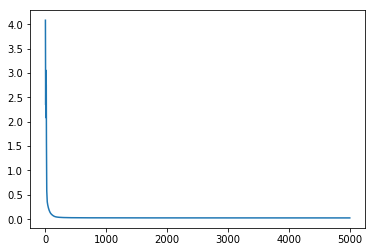

In [155]:
epochs = 5000
lr = 0.1
nn = NeuralNetwork(x.T, y.T, params={'lr': lr, 'ln': [4, 8], 'activation': 'tanh'})

nn.forward_prop(one_hot=True)
loss = nn.backward_prop(epochs)

print(f'accuracy score: {accuracy_score(nn.forward_prop(one_hot=True), y)}')

plt.plot(np.arange(epochs), loss)
plt.show()